SA on game comments

model: GloVe + CNN (or BiLSTM whatsoever??)

The training script to run (as training this is fast)

---

In [1]:
import sys
 
# setting path for common utils script
sys.path.append('../')

import str_cleaning_functions
import dataset_loader

In [152]:
from pathlib import Path
from datetime import datetime

# build training output folder (storing the models)

# set some parameters of this training
DATASET_LIST = [120, 240, 480]
DATASET_LIST_INDEX = 0
DATASET_SIZE = DATASET_LIST[DATASET_LIST_INDEX]
DATASET_IS_BALANCED = True

# max_tokens for TextVectorization layer
# max_tokens shd be equal to that in tfidf (for fair comparison)
MAX_TOKENS = 20000

training_name = 'glove-cnn-{}_{}k_{}'.format(
    MAX_TOKENS,
    DATASET_LIST[DATASET_LIST_INDEX],
    'bal' if DATASET_IS_BALANCED else 'imbal')

training_date = datetime.today()

training_name = f'{training_name}_{training_date.strftime("%Y-%m-%d")}'

training_output_folder = Path(f'{training_name}/').resolve()

if not training_output_folder.exists():
    training_output_folder.mkdir(parents=True, exist_ok=False)

Load the pre-sampled dataset

In [153]:
# load the pre-sampled dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# training_args_datetime = datetime(year=2023, month=12, day=18)
# training_storing_folder = Path(training_name).resolve()

# X_imbal_valid, y_imbal_valid, X_bal_valid, y_bal_valid = dataset_loader.load_presampled_validation_dataset()

X_train, X_test, y_train, y_test = dataset_loader.load_presampled_traintest_dataset(DATASET_SIZE, DATASET_IS_BALANCED)

Loaded dataset size: 120k, is_balanced: True

Training dataset class distribution
review_score
0    54060
1    53940
Name: count, dtype: int64
Testing dataset class distribution
review_score
1    6060
0    5940
Name: count, dtype: int64





---

Any data augmentation plz add here

In [154]:
# TODO: add data augmentation here

---

Data cleaning

This is customized to each model, as each model has their own limitation to the dataset

No rows will be removed in this step

In [155]:
# define your own cleaning function

def cleaning_arr(str_arr):
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_links(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_links2(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.clean(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.deEmojify(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_non_letters(x))
    str_arr = str_arr.apply(lambda x: x.lower())
    # str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_stopword(x))      # no need to remove stopwords, as glove is trained with stopwords
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.unify_whitespaces(x))
    # str_arr = str_arr.apply(lambda x: str_cleaning_functions.stemming(x))


    return str_arr

In [156]:
X_train = cleaning_arr(X_train)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [157]:
X_test = cleaning_arr(X_test)
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [158]:
# check shapes

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(108000,)
(108000,)

(12000,)
(12000,)


---

Training phrase

Create tf dataset object for efficient loading during training

In [159]:
class_names = np.unique(y_train)
print(class_names)

[0 1]


In [160]:
# some constants for the model

# embedding dimension (dimension of glove dataset)
EMBEDDING_DIM = 300

# for text vectorization layer
SEQUENCE_LENGTH = 512
MAX_TOKENS = 20000

In [161]:
import tensorflow as tf

# create a tensorflow dataset object

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [162]:
# shuffle the training dataset, as we want to randomize the training process
# shuffle before batch

buffer_size = 10000

train_dataset = train_dataset.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)

In [163]:
# batch datasets

BATCH_SIZE = 128

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
# valid_dataset = valid_dataset.batch(BATCH_SIZE)

In [164]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {label[0]}")
    print()

Abstract: b'the best sci fi x ever made '
Label(s): 1

Abstract: b'the concept for the game is really good but the execution is awful hitboxes and sprites don t seem to match up too well only one music track per world which constantly loops throughout the world the entire game including the deluxe content only levels can be beat in minutes the only reason to replay is to get gold on each level the level design is also fairly shoddy imo one level that sticks out in my memory involved jumping bouncing on a rolling enemy and practically nothing else it sounds easy to do but the jump had to have perfect timing or else you d die you also had to know that the rolling enemy only detects collision inside of the enemy the idea of playing a game in reverse is a novel one but spoiler alert is a product that fails this idea entirely if you really need to play this for some reason please buy the normal version the deluxe edition only has extra levels each seconds long and a level editor '
Label(s):

Create a vocabulary index

Let's use the TextVectorization to index the vocabulary found in the dataset. Later, we'll use the same layer instance to vectorize the samples.

Our layer will only consider the top N words, and will truncate or pad sequences to be actually 200 tokens long.

In [165]:
# import tensorflow as tf
# from tensorflow.keras.layers import TextVectorization

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,                          # same as TFIDF-RF one
    output_sequence_length=SEQUENCE_LENGTH)         # same as BERT
# text_ds = tf.data.Dataset.from_tensor_slices(X_train_subset)
vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [166]:
vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'and', 'to', 'a', 'game', 'i', 'it', 'of']

In [167]:
output = vectorizer([["the game looks awesome"]])
print(output.numpy()[0, :])
print(output.numpy().shape)

[  2   6 281 231   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

load pre-trained word embeddings

Download your own and save it under dev-workspace/sa/

In [168]:
glove_file_path = Path(f"../glove.6B/glove.6B.{EMBEDDING_DIM}d.txt").resolve()

embeddings_index = {}
with open(glove_file_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. 

It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [169]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18163 words (1837 misses)


Next, we load the pre-trained word embeddings matrix into an Embedding layer.

Note that we set trainable=False so as to keep the embeddings fixed (we don't want to update them during training).

In [170]:
import keras
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    EMBEDDING_DIM,
    trainable=True,
)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

Build the model

The model we eventually implemented is borrowed from the original paper proposed CNN text classification, and further studies on parameters settings

In [171]:
from tensorflow.keras import layers

# model from paper: https://www.aclweb.org/anthology/D14-1181.pdf
# implementation (tf): https://github.com/dennybritz/cnn-text-classification-tf/blob/master/text_cnn.py


# more paper: https://arxiv.org/pdf/1510.03820.pdf (parameters selection)
# more paper (a recent one, from China+Philippines): https://downloads.hindawi.com/journals/js/2022/7212366.pdf
# more paper (a recent from Indonesia): https://www.jatit.org/volumes/Vol100No2/5Vol100No2.pdf

# more reference: https://www.kaggle.com/code/poigal/cnn-on-glove-word-embedding

sequence_length = SEQUENCE_LENGTH
filter_sizes = [7, 7, 7]
num_filters = 128
drop_rate = 0.3

int_sequences_input = keras.Input(shape=(sequence_length,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
# reshape = layers.Reshape((sequence_length,EMBEDDING_DIM,1))(embedded_sequences)

conv0 = layers.Conv1D(128, filter_sizes[0], activation="relu")(embedded_sequences)
conv1 = layers.Conv1D(128, filter_sizes[1], activation="relu")(embedded_sequences)
conv2 = layers.Conv1D(128, filter_sizes[2], activation="relu")(embedded_sequences)


maxpool0 = layers.MaxPooling1D(sequence_length - filter_sizes[0] + 1, strides=1, padding='valid')(conv0)
maxpool1 = layers.MaxPooling1D(sequence_length - filter_sizes[1] + 1, strides=1, padding='valid')(conv1)
maxpool2 = layers.MaxPooling1D(sequence_length - filter_sizes[2] + 1, strides=1, padding='valid')(conv2)

# concate the output of three maxpool layers
concatenated_tensor = layers.concatenate([maxpool0, maxpool1, maxpool2])
flatten = layers.Flatten()(concatenated_tensor)
dropout = layers.Dropout(drop_rate)(flatten)
preds = layers.Dense(len(class_names), activation="softmax")(dropout)

model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 512, 300)             6000600   ['input_9[0][0]']             
                                                                                                  
 conv1d_12 (Conv1D)          (None, 506, 128)             268928    ['embedding_4[0][0]']         
                                                                                                  
 conv1d_13 (Conv1D)          (None, 506, 128)             268928    ['embedding_4[0][0]']         
                                                                                            

In [172]:
# build the plot of the model
# You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.

# tf.keras.utils.plot_model(
#     model,
#     to_file=f"{training_output_folder}/model_plot.png",
#     show_shapes=True,
#     # show_layer_names=True,
#     expand_nested=True,
#     dpi=300,
# )

apply the vectorizer to transform the strings to indices

apply to all three datasets

In [173]:
train_dataset = train_dataset.map(lambda x, y: (vectorizer(x), y)).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (vectorizer(x), y)).prefetch(tf.data.AUTOTUNE)
# valid_dataset = valid_dataset.map(lambda x, y: (vectorizer(x), y)).prefetch(tf.data.AUTOTUNE)

In [174]:
for elem in train_dataset.as_numpy_iterator():
    if elem[0].shape[1] != 512:
        print('find one not equal with 512')
        print('its shape = ', elem[0].shape)
        print(elem)

In [175]:
tt = train_dataset.take(3).as_numpy_iterator()
for elem in tt:
    print(elem)
    print(elem[0].shape)
    print()
    break

(array([[ 25,  10,  22, ...,   0,   0,   0],
       [ 12,  11,   2, ...,   0,   0,   0],
       [233,  27, 809, ...,   0,   0,   0],
       ...,
       [ 12,   6,  11, ...,   0,   0,   0],
       [  7,  23,  62, ...,   0,   0,   0],
       [ 37,  18,   5, ...,   0,   0,   0]]), array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]))
(128, 512)



training

In [176]:
# copy from the cell above

# TODO: add more metrics
# examples
from keras.src.callbacks import ReduceLROnPlateau
from keras.optimizers.schedules import ExponentialDecay


metrics = [
    keras.metrics.SparseCategoricalAccuracy(),
    # keras.metrics.FalseNegatives(name="fn", thresholds=0),
    # keras.metrics.FalsePositives(name="fp"),
    # keras.metrics.TrueNegatives(name="tn"),
    # keras.metrics.TruePositives(name="tp"),
    # keras.metrics.Precision(name="precision"),
    # keras.metrics.Recall(name="recall")
]

# using legacy optimizers because of compatability issue
# model.compile(
#     loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), metrics=metrics
# )

LEARNING_RATE = 1e-3

# model.compile(
#     loss="sparse_categorical_crossentropy", 
#     optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999),      # state the default setting of beta_1 and beta_2 explicitly
#     metrics=metrics
# )

# reduce learning rate when loss is not decreasing
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
#                               patience=1, min_lr=0, verbose=1)


model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=ExponentialDecay(
            LEARNING_RATE,
            decay_steps=X_train.shape[0] // BATCH_SIZE,
            decay_rate=0.99,
            staircase=True),            # with learning rate decay in each epoch
        beta_1=0.9, beta_2=0.999),      # state the default setting of beta_1 and beta_2 explicitly
    metrics=metrics
)

# save the model with best accuracy, regardless of the val_loss
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=Path(f'{training_output_folder}/{training_name}_best_model.h5').resolve(),
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# define tensorboard callback for revisiting data
tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir=Path(f'{training_output_folder}/logs').resolve())]

# apply early stopping to avoid overfit
early_stoping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# try to use weighted samples to avoid data imbalance
# so as the test
history_model = model.fit(
    train_dataset,
    epochs=20, 
    validation_data=test_dataset,
    # callbacks=[early_stoping_callback, reduce_lr, tensorboard_callback] 
    callbacks=[early_stoping_callback, tensorboard_callback] 
)

Epoch 1/20


844/844 [==============================] - 34s 40ms/step - loss: 0.3938 - sparse_categorical_accuracy: 0.8220 - val_loss: 0.3170 - val_sparse_categorical_accuracy: 0.8631
Epoch 2/20
844/844 [==============================] - 21s 25ms/step - loss: 0.2648 - sparse_categorical_accuracy: 0.8892 - val_loss: 0.3028 - val_sparse_categorical_accuracy: 0.8726
Epoch 3/20
844/844 [==============================] - 17s 20ms/step - loss: 0.1996 - sparse_categorical_accuracy: 0.9200 - val_loss: 0.3373 - val_sparse_categorical_accuracy: 0.8717
Epoch 4/20
844/844 [==============================] - 16s 19ms/step - loss: 0.1430 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.3820 - val_sparse_categorical_accuracy: 0.8708
Epoch 5/20
844/844 [==============================] - 16s 19ms/step - loss: 0.1054 - sparse_categorical_accuracy: 0.9604 - val_loss: 0.4395 - val_sparse_categorical_accuracy: 0.8673
Epoch 6/20
844/844 [==============================] - 16s 18ms/step - loss: 0.0804 - sparse_categoric

In [177]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# func from: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

def plot_metrics(history):
  metrics = ['loss', 'sparse_categorical_accuracy']
  plt.style.use('seaborn-v0_8')
  # plt.style.use('seaborn-v0_8-dark')
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.title('Training metrics')
    plt.legend()

    # save the graph
    plt.savefig(Path(f'{training_output_folder}/train_history_{training_name}_{training_date.strftime("%Y-%m-%d")}_trainingmetrics.png').resolve(),
                dpi=600, bbox_inches='tight')

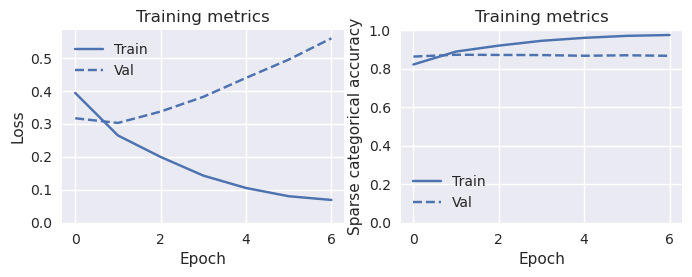

In [178]:
plot_metrics(history_model)

---

Save the model and training history (for reproduce the graph and test result)

In [179]:
import pickle

with open(Path.joinpath(training_output_folder, 'train-history_{}_{}/'.format(
    training_name,
    training_date.strftime("%Y-%m-%d"))), 'wb') as file_pi:
    
        pickle.dump(history_model.history, file_pi)

In [180]:
# load training history

# from datetime import datetime
# import pickle

# with open(Path.joinpath(training_output_folder, 'train-history_{}_{}/'.format(
#     training_name,
#     training_date.strftime("%Y-%m-%d")
#     )), 'rb') as file_pi:
#         history_model_loaded = pickle.load(file_pi)

In [181]:
# history_model_loaded

In [182]:
# save text vectorizer

with open(Path.joinpath(training_output_folder, "{}_textvectorizer.pkl".format(
                training_name)
            ), 'wb') as f:
    

    pickle.dump({'config': vectorizer.get_config(),
                'weights': vectorizer.get_weights()}
                , f)

---

In [183]:
# load text vectorizer

# from_disk = pickle.load(open(Path.joinpath(
#     training_output_folder,
#     "{}_{}_textvectorizer.pkl".format(
#                 training_name,
#                 training_date.strftime("%Y-%m-%d"))
#             ), "rb"))

# vectorizer_loaded = tf.keras.layers.TextVectorization(
#     max_tokens=20000, 
#     output_sequence_length=512)

# vectorizer_loaded.set_weights(from_disk['weights'])

In [184]:
# output2 = vectorizer_loaded([["the game looks awesome"]])
# print(output2.numpy()[0, :])
# print(output2.numpy().shape)

In [185]:
# save the model itself

model.save(Path.joinpath(
    training_output_folder,
    '{}_model.keras'.format(
        training_name)
    ))

In [186]:
# load the model itself

# model_loaded = keras.models.load_model(Path.joinpath(
#     training_output_folder,
#     '{}_{}_model.keras'.format(
#         training_name)
# ))

In [187]:
# model_loaded.summary()

---

Save the model (a end2end pipeline for single string)

In [188]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

In [189]:
end_to_end_model.save(Path.joinpath(
    training_output_folder,
    '{}_end2end.keras'.format(
        training_name)
))

In [39]:
# string_input = keras.Input(shape=(1,), dtype="string")
# x = vectorizer_loaded(string_input)
# preds = model_loaded(x)
# end_to_end_model = keras.Model(string_input, preds)

In [ ]:
# positive reviews
# the third one is an actual postitive review from AC6
# https://steamcommunity.com/id/bromancedance/recommended/1888160/

probabilities = end_to_end_model.predict(
    [["The game deserves a game of the year"], ["I enjoy playing it very much"], ["Fun, FUN, FUN!!!!!! Souls is one of my favorite series of all time, but never tried an AC game before this one. This game is the most fun I've had in a game in so long. Not just the high points, but the pacing just keeps you in the fun seat CONSTANTLY. After playing Starfield and Baldurs Gate 3 recently it felt ILLEGAL how often I was having a blast. I was constantly ready for the point of the game where the fun would slow down, but it only ramps up. TRULY a breath of fresh air in todays gaming climate."]]
)

for prob in probabilities:
    print('output:', prob, '; class:', np.argmax(prob))

1/1 [==============================] - 0s 108ms/step
output: [0.02418574 0.9758143 ] ; class: 1
output: [0.2268303 0.7731697] ; class: 1
output: [0.00650699 0.993493  ] ; class: 1


In [ ]:
# negative reviews
# the second one: https://steamcommunity.com/id/x-pert_bandit/recommended/1091500/
# the third one: https://steamcommunity.com/profiles/76561197960511970/recommended/1716740/

probabilities = end_to_end_model.predict(
    [["Buying this game is wasting my money."], ["Now before all else is said, it is a good game, if it wasn't I wouldn't have put in so many hours elsewise. But save your cash until they've fixed a majority of the bugs and optimized it a bit more."], ["It is not a bad game. If you want Fallout in Space with dogfights, it absolutely delivers that. But the problems are that it feels very dated. The voice-acting and writing are embarrassingly bad, especially after coming off Baldurs Gate 3 where I found myself caring deeply about the characters and their stories. Starfield makes me want to skip dialog as fast as possible because it is so cringey. The main plot is about as cliched and uninspired as you can imagine. You are a no-name miner, but suddenly you are the crux of the whole plot and everyone just decides to make you the chosen one to do all the important stuff in a pre-existing group for no reason at all. It makes absolutely no sense when they had someone in their organization who had already experienced the mcguffin. The more I play it, the less I like it from the plot perspective. If people aren't playing for the plot, their experience will likely be better, but I still find the game feeling dated... Looks like I've played too much to refund it, which is disappointing, but the same issues still remain. The writing and voice-acting are reminiscent of a game from 1995 and really hold this game back."]]
)

for prob in probabilities:
    print('output:', prob, '; class:', np.argmax(prob))

1/1 [==============================] - 0s 20ms/step
output: [0.95612025 0.04387974] ; class: 0
output: [0.84603477 0.15396526] ; class: 0
output: [0.9939925  0.00600743] ; class: 0


In [42]:
# load end to end model

# end_to_end_model_loaded = keras.models.load_model(Path.joinpath(
#     training_output_folder,
#     '{}_{}_end2end.keras'.format(
#         training_name,
#         training_date.strftime("%Y-%m-%d"))
# ))

# end_to_end_model_loaded.summary()

---

Training ends